In [1]:
# splicing categories are pairwise (do they need a reference?)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from venn import venn

from data_loading import (load_annotated_6k_collection,
    load_annotated_gencode_tfs, 
    load_tf_families,
    load_y2h_isoform_data, 
    load_y1h_pdi_data, 
    load_valid_isoform_clones,
    load_ref_vs_alt_isoforms_table,
    load_m1h_activation_data)

In [2]:
tfs = load_annotated_6k_collection()
tfs_gc = load_annotated_gencode_tfs()
tf_fam = load_tf_families()
m1h = load_m1h_activation_data()
y2h = load_y2h_isoform_data()
y1h = load_y1h_pdi_data()
isoforms = load_valid_isoform_clones()
pairs = load_ref_vs_alt_isoforms_table()
pairs['clone_name_ref'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['clone_name_alt'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

reading from cache
reading from cache


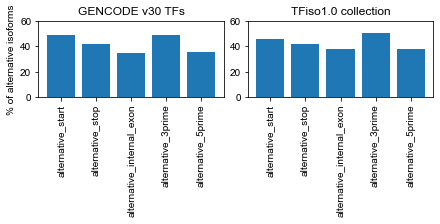

In [3]:
# loop over pairs of isoforms, get fraction of different categories
cats_6k = {k: 0 for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
cats_gc = {k: 0 for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
n_6k = 0
n_gc = 0
for tf in tfs.values():
    ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
    for alt_iso in [x.name for x in tf.orfs]:
        if alt_iso == ref_iso:
            continue
        n_6k += 1
        if tf.alternative_start(ref_iso, alt_iso):
            cats_6k['alternative_start'] += 1
        if tf.alternative_stop(ref_iso, alt_iso):
            cats_6k['alternative_stop'] += 1
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats_6k['alternative_internal_exon'] += 1
        if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
            cats_6k['alternative_3prime'] += 1
        if tf.alternative_5prime_donor(ref_iso, alt_iso):
            cats_6k['alternative_5prime'] += 1
for tf in tfs_gc.values():
    ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
    for alt_iso in [x.name for x in tf.orfs]:
        if alt_iso == ref_iso:
            continue
        n_gc += 1
        if tf.alternative_start(ref_iso, alt_iso):
            cats_gc['alternative_start'] += 1
        if tf.alternative_stop(ref_iso, alt_iso):
            cats_gc['alternative_stop'] += 1
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats_gc['alternative_internal_exon'] += 1
        if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
            cats_gc['alternative_3prime'] += 1
        if tf.alternative_5prime_donor(ref_iso, alt_iso):
            cats_gc['alternative_5prime'] += 1

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(6, 3)
axs[0].bar(cats_gc.keys(),
           [(x / n_gc) * 100 for x in cats_gc.values()])
axs[1].bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 60)
axs[0].set_ylabel('% of alternative isoforms')
axs[0].set_title('GENCODE v30 TFs')
axs[1].set_title('TFiso1.0 collection')
plt.savefig('../figures/splicing-categories-pct_GENCODE-vs-TFiso1_bar.pdf',
            bbox_inches='tight')
plt.show()

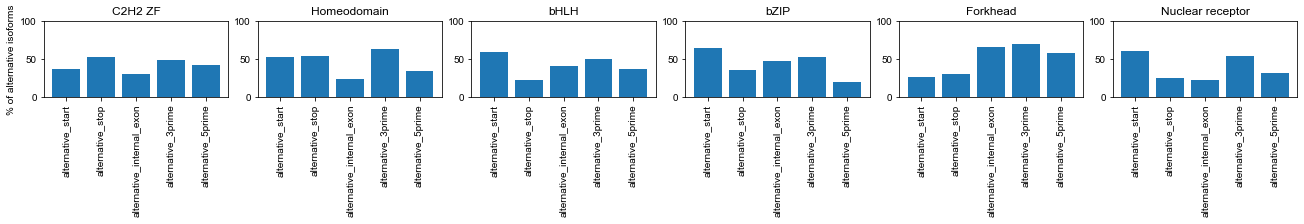

In [4]:
families = ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']
fig, axs = plt.subplots(1, len(families))
fig.set_size_inches(3 * len(families), 3)
for family, ax in zip(families, axs):
    cats_6k = {k: 0 for k in ['alternative_start',
                            'alternative_stop',
                            'alternative_internal_exon',
                            'alternative_3prime',
                            'alternative_5prime']}
    n_6k = 0
    for tf in tfs.values():
        if tf_fam[tf.name] != family:
            continue
        ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
        for alt_iso in [x.name for x in tf.orfs]:
            if alt_iso == ref_iso:
                continue
            n_6k += 1
            if tf.alternative_start(ref_iso, alt_iso):
                cats_6k['alternative_start'] += 1
            if tf.alternative_stop(ref_iso, alt_iso):
                cats_6k['alternative_stop'] += 1
            if tf.alternative_internal_exon(ref_iso, alt_iso):
                cats_6k['alternative_internal_exon'] += 1
            if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
                cats_6k['alternative_3prime'] += 1
            if tf.alternative_5prime_donor(ref_iso, alt_iso):
                cats_6k['alternative_5prime'] += 1
    ax.bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
    ax.set_title(family)
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 100)
axs[0].set_ylabel('% of alternative isoforms')
plt.savefig('../figures/splicing-categories-pct_TFiso1_by-TF-family_bar.pdf',
            bbox_inches='tight')

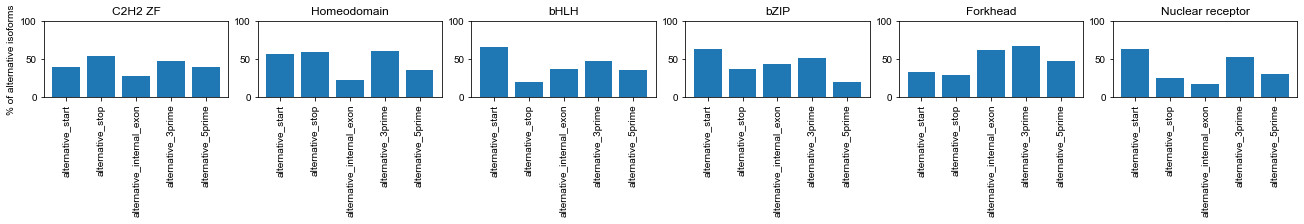

In [5]:
families = ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']
fig, axs = plt.subplots(1, len(families))
fig.set_size_inches(3 * len(families), 3)
for family, ax in zip(families, axs):
    cats_6k = {k: 0 for k in ['alternative_start',
                            'alternative_stop',
                            'alternative_internal_exon',
                            'alternative_3prime',
                            'alternative_5prime']}
    n_6k = 0
    for tf in tfs_gc.values():
        if tf.name not in tf_fam or tf_fam[tf.name] != family:
            continue
        ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
        for alt_iso in [x.name for x in tf.orfs]:
            if alt_iso == ref_iso:
                continue
            n_6k += 1
            if tf.alternative_start(ref_iso, alt_iso):
                cats_6k['alternative_start'] += 1
            if tf.alternative_stop(ref_iso, alt_iso):
                cats_6k['alternative_stop'] += 1
            if tf.alternative_internal_exon(ref_iso, alt_iso):
                cats_6k['alternative_internal_exon'] += 1
            if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
                cats_6k['alternative_3prime'] += 1
            if tf.alternative_5prime_donor(ref_iso, alt_iso):
                cats_6k['alternative_5prime'] += 1
    ax.bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
    ax.set_title(family)
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 100)
axs[0].set_ylabel('% of alternative isoforms')
plt.savefig('../figures/splicing-categories-pct_Gencode_by-TF-family_bar.pdf',
            bbox_inches='tight')
plt.show()

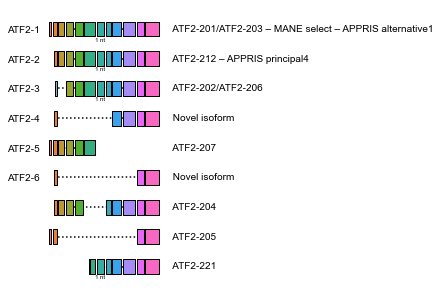

In [6]:
tfs['ATF2'].exon_diagram()

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


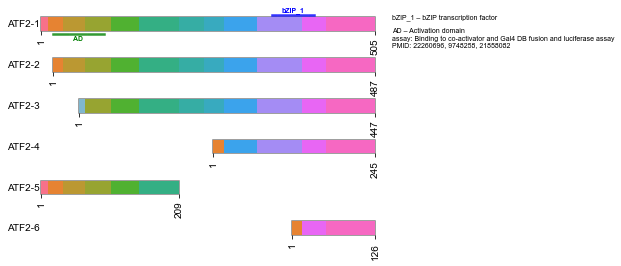

In [7]:
tfs['ATF2'].protein_diagram()

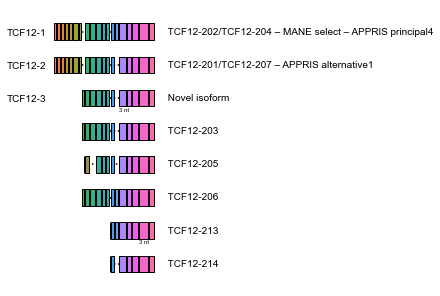

In [8]:
tfs['TCF12'].exon_diagram()

In [9]:
tfs['TCF12'].strand

'+'

In [10]:
# is this true?
tfs['TCF12'].alternative_3prime_acceptor('TCF12-2', 'TCF12-3')

True

In [11]:
cats = {k: set() for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
for tf in tfs.values():
    ref_iso = tf.orfs[0].name
    for alt_iso in [x.name for x in tf.orfs[1:]]:
        if tf.alternative_start(ref_iso, alt_iso):
            cats['alternative_start'].add((ref_iso, alt_iso))
        if tf.alternative_stop(ref_iso, alt_iso):
            cats['alternative_stop'].add((ref_iso, alt_iso))
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats['alternative_internal_exon'].add((ref_iso, alt_iso))
        if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
            cats['alternative_3prime'].add((ref_iso, alt_iso))
        if tf.alternative_5prime_donor(ref_iso, alt_iso):
            cats['alternative_5prime'].add((ref_iso, alt_iso))

In [12]:
for k, v in cats.items():
    print(k, len(v))

alternative_start 463
alternative_stop 458
alternative_internal_exon 377
alternative_3prime 536
alternative_5prime 403


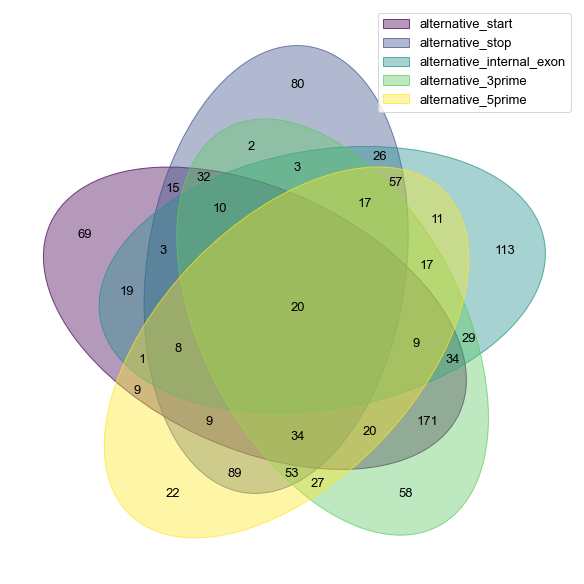

In [13]:
venn(cats)
plt.savefig('../figures/splice-cat_venn.pdf',
            bbox_inches='tight')

In [14]:
# what are the alt. stops that don't have other cats???
cats['alternative_stop'].difference(set.union(*(v for k, v in cats.items() if k != 'alternative_stop')))

{('AEBP2-2', 'AEBP2-207'),
 ('ATF3-1', 'ATF3-2'),
 ('CREM-1', 'CREM-201'),
 ('ESR2-1', 'ESR2-2'),
 ('ESR2-1', 'ESR2-202'),
 ('ESR2-1', 'ESR2-206'),
 ('ESR2-1', 'ESR2-212'),
 ('ETV7-1', 'ETV7-201'),
 ('FOXP2-1', 'FOXP2-10'),
 ('GRHL3-1', 'GRHL3-3'),
 ('HSFY1-1', 'HSFY1-2'),
 ('KLF12-1', 'KLF12-2'),
 ('MAX-1', 'MAX-216'),
 ('MAX-1', 'MAX-5'),
 ('MAZ-2', 'MAZ-212'),
 ('MEIS2-1', 'MEIS2-206'),
 ('MITF-2', 'MITF-3'),
 ('NKX2-5-1', 'NKX2-5-2'),
 ('NKX2-5-1', 'NKX2-5-204'),
 ('NR3C1-1', 'NR3C1-205'),
 ('PATZ1-1', 'PATZ1-2'),
 ('PBX1-1', 'PBX1-209'),
 ('PBX1-1', 'PBX1-222'),
 ('PRDM5-1', 'PRDM5-3'),
 ('PRRX1-1', 'PRRX1-2'),
 ('RFX3-2', 'RFX3-203'),
 ('RORC-2', 'RORC-4'),
 ('RUNX1-1', 'RUNX1-203'),
 ('SMAD4-1', 'SMAD4-2'),
 ('TBX18-2', 'TBX18-3'),
 ('TCF7L2-1', 'TCF7L2-2'),
 ('THAP6-1', 'THAP6-209'),
 ('TP53-1', 'TP53-204'),
 ('TP53-1', 'TP53-206'),
 ('TP63-1', 'TP63-207'),
 ('TSHZ3-2', 'TSHZ3-201'),
 ('ZBTB25-1', 'ZBTB25-4'),
 ('ZKSCAN7-1', 'ZKSCAN7-201'),
 ('ZNF124-1', 'ZNF124-204'),
 ('ZNF12

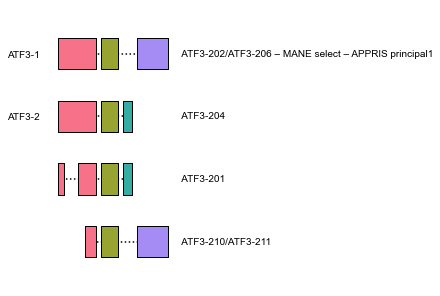

In [15]:
tfs['ATF3'].exon_diagram()

In [16]:
tfs['ATF2'].alternative_3prime_acceptor('ATF2-1', 'ATF2-2')

True

In [17]:
cats.keys()

dict_keys(['alternative_start', 'alternative_stop', 'alternative_internal_exon', 'alternative_3prime', 'alternative_5prime'])

In [18]:
for cat_name, members in cats.items():
    pairs[cat_name] = pairs.apply(lambda x: (x['clone_name_ref'], x['clone_name_alt']) in members,
                                  axis=1)

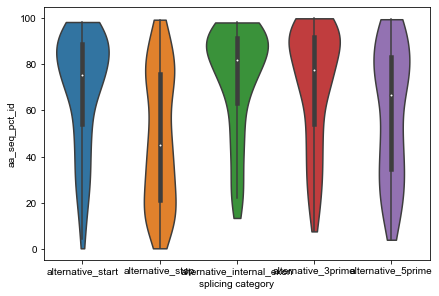

In [19]:
sns.violinplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'aa_seq_pct_id'].values], 
                    columns=['splicing category', 'aa_seq_pct_id']),
                x='splicing category',
                y='aa_seq_pct_id',
                cut=0)
plt.show()

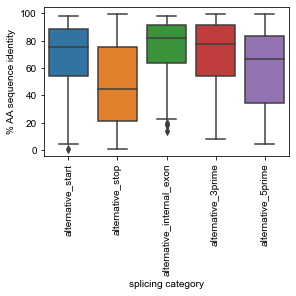

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
sns.boxplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'aa_seq_pct_id'].values], 
                    columns=['splicing category', '% AA sequence identity']),
                x='splicing category',
                y='% AA sequence identity',
                ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.savefig('../figures/aa-seq-id_by_splice-cat_box-plot.pdf',
            bbox_inches='tight')
plt.show()

In [22]:
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,clone_name_ref,clone_name_alt,alternative_start,alternative_stop,alternative_internal_exon,alternative_3prime,alternative_5prime
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,ZBTB18-1,ZBTB18-2,True,False,False,True,False
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,PRRX1-2,PRRX1-1,False,False,False,False,False
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,9.0,11.0,11.0,9.0,9.0,0.818182,True,1.552087,0.773129,-0.778958,PRRX1-2,PRRX1-3,False,False,False,False,False
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,POU2F1-2,POU2F1-1,False,False,False,False,False
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,ATF3-1,ATF3-2,False,True,False,False,False


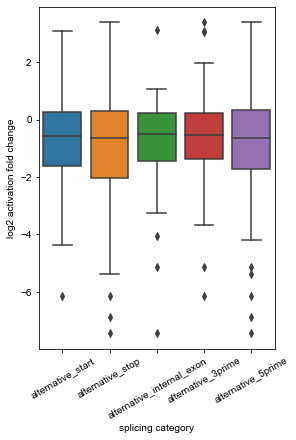

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 6)
sns.boxplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'activation_fold_change_log2'].values], 
                    columns=['splicing category', 'log2 activation fold change']),
                x='splicing category',
                y='log2 activation fold change',
                ax=ax)
ax.xaxis.set_tick_params(rotation=30)
plt.savefig('../figures/m1h-change_by_splice-cat_box-plot.pdf',
            bbox_inches='tight')
plt.show()
plt.show()

<ipython-input-25-d9f0e914feb1>:15: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


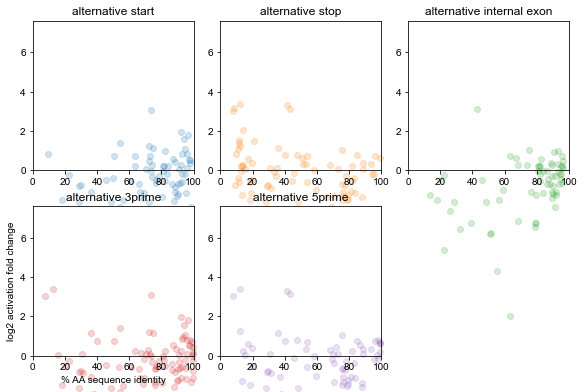

In [25]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(8, 8/3*2)
for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
    xy = pairs.loc[pairs[cat], ['aa_seq_pct_id', 'activation_fold_change_log2']].dropna()
    ax.scatter(x=xy['aa_seq_pct_id'], y=xy['activation_fold_change_log2'],
               alpha=0.2,
               clip_on=False,
               color='C' + str(i))
    ax.set_ylim(0, 7.6)
    ax.set_xlim(0, 100)
    ax.set_title(cat.replace('_', ' '))
axs[-1, -1].axis('off')
axs[-1, 0].set_xlabel('% AA sequence identity')
axs[-1, 0].set_ylabel('log2 activation fold change')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('../figures/aa-seq_id_vs_m1h-change_by_splice-cat_scatter.pdf',
            bbox_inches='tight')

In [28]:
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,clone_name_ref,clone_name_alt,alternative_start,alternative_stop,alternative_internal_exon,alternative_3prime,alternative_5prime
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,ZBTB18-1,ZBTB18-2,True,False,False,True,False
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,PRRX1-2,PRRX1-1,False,False,False,False,False
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,9.0,11.0,11.0,9.0,9.0,0.818182,True,1.552087,0.773129,-0.778958,PRRX1-2,PRRX1-3,False,False,False,False,False
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,POU2F1-2,POU2F1-1,False,False,False,False,False
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,ATF3-1,ATF3-2,False,True,False,False,False


<ipython-input-29-c075a1d13d43>:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


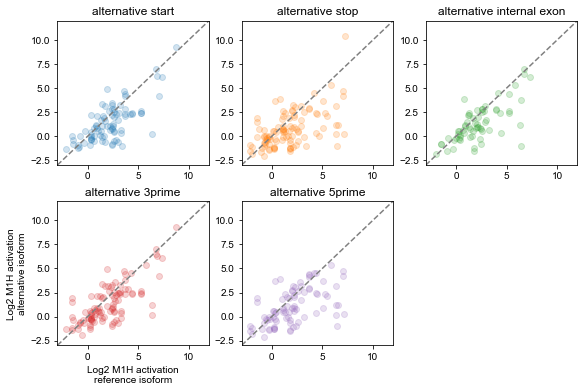

In [29]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(8, 8/3*2)
for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
    xy = pairs.loc[pairs[cat], ['activation_ref', 'activation_alt']].dropna()
    ax.scatter(x=xy['activation_ref'], y=xy['activation_alt'],
               alpha=0.2,
               clip_on=False,
               color='C' + str(i))
    ax.plot([-3, 12], [-3, 12], linestyle='--', color='grey')
    ax.set_ylim(-3, 12)
    ax.set_xlim(-3, 12)
    ax.set_title(cat.replace('_', ' '))
axs[-1, -1].axis('off')
axs[-1, 0].set_xlabel('Log2 M1H activation\nreference isoform')
axs[-1, 0].set_ylabel('Log2 M1H activation\nalternative isoform')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('../figures/m1h-per-pair_by_splice-cat_scatter.pdf',
            bbox_inches='tight')

<ipython-input-30-86870607f9fa>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-30-86870607f9fa>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-30-86870607f9fa>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-30-86870607f9fa>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-30-86870607f9fa>:17: UserWarning: This figure was using a layout engine that is incom

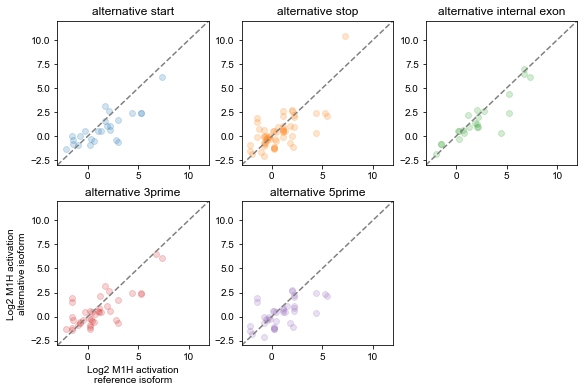

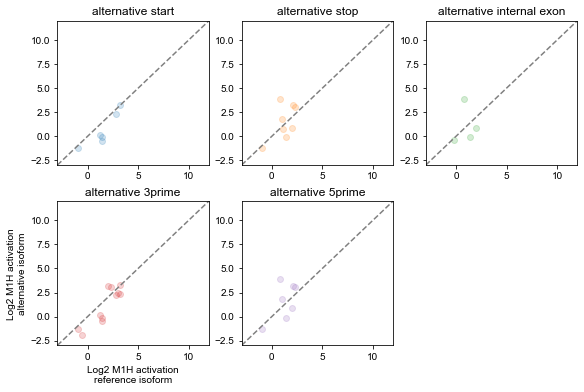

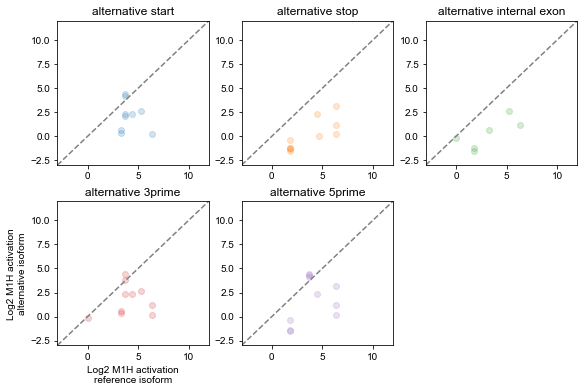

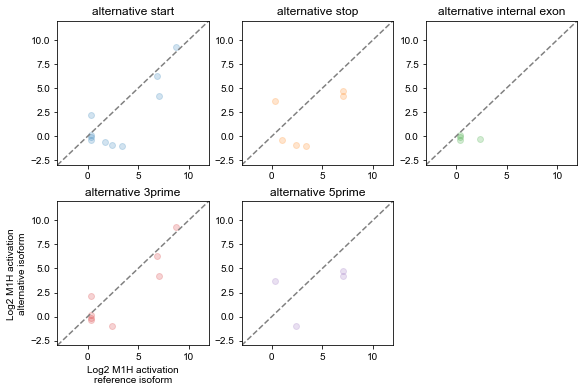

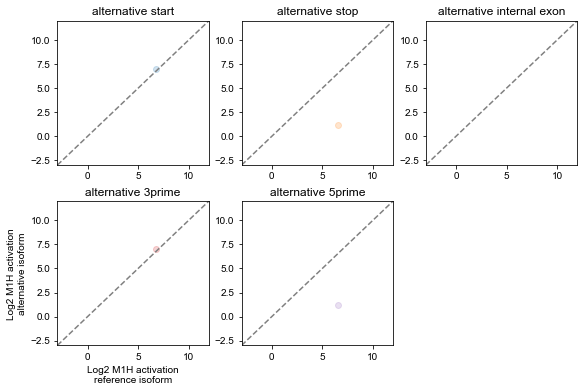

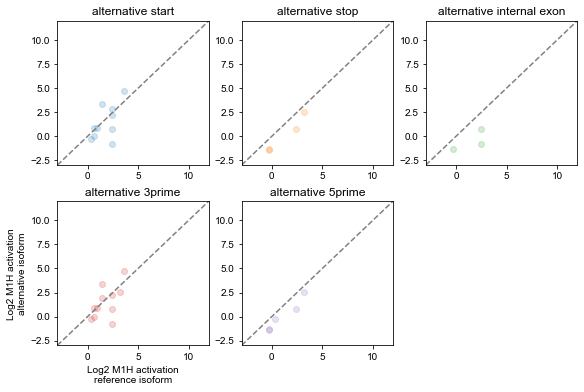

In [30]:
for family in ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']:
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(8, 8/3*2)
    for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
        xy = pairs.loc[pairs[cat] & (pairs['family'] == family), ['activation_ref', 'activation_alt']].dropna()
        ax.scatter(x=xy['activation_ref'], y=xy['activation_alt'],
                alpha=0.2,
                clip_on=False,
                color='C' + str(i))
        ax.plot([-3, 12], [-3, 12], linestyle='--', color='grey')
        ax.set_ylim(-3, 12)
        ax.set_xlim(-3, 12)
        ax.set_title(cat.replace('_', ' '))
    axs[-1, -1].axis('off')
    axs[-1, 0].set_xlabel('Log2 M1H activation\nreference isoform')
    axs[-1, 0].set_ylabel('Log2 M1H activation\nalternative isoform')
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.savefig('../figures/m1h-per-pair_by_splice-cat_scatter_{}.pdf'.format(family),
                bbox_inches='tight')

In [31]:
tf_fam.value_counts().head(10)

C2H2 ZF             747
Homeodomain         196
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
T-box                17
Name: DBD, dtype: int64

In [34]:
# look at examples where small change in aa sequence is large change in M1H


# FOXJ2-1	FOXJ2-2	
# TBPL1-1	TBPL1-2	
# NR4A1-1/2/3

pairs.loc[pairs['alternative_3prime']
          & (pairs['activation_fold_change_log2'].abs() > 3.), :].sort_values('aa_seq_pct_id', ascending=False)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,clone_name_ref,clone_name_alt,alternative_start,alternative_stop,alternative_internal_exon,alternative_3prime,alternative_5prime
224,E2F8,ENSG00000129173,E2F,True,E2F8|1/4|03G03,E2F8|2/4|03A06,ENST00000250024|ENST00000527884|ENST00000620009,NaN,False,True,True,867,842,12,12,False,False,False,False,True,False,False,False,1.0,16.774194,True,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.318486,-0.146185,-3.464671,E2F8-1,E2F8-2,False,False,False,True,False
300,ZNF778,ENSG00000170100,C2H2 ZF,False,ZNF778|1/2|05B07,ZNF778|2/2|12G05,ENST00000433976,ENST00000306502,False,False,True,757,687,6,4,True,False,False,False,True,False,False,False,0.0,0.000000,False,90.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.837186,-0.398220,-3.235406,ZNF778-1,ZNF778-2,True,False,False,True,False
46,E2F6,ENSG00000169016,E2F,True,E2F6|1/2|10C02,E2F6|2/2|01A04,ENST00000381525,ENST00000542100|ENST00000546212,False,False,True,281,206,7,5,True,False,False,False,True,False,False,False,0.0,18.461538,True,73.3,2.0,0.0,2.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.873302,4.948795,3.075493,E2F6-1,E2F6-2,True,False,False,True,False
166,TFEC,ENSG00000105967,bHLH,True,TFEC|1/6|03F07,TFEC|6/6|03E11,ENST00000265440,NaN,False,True,True,347,196,7,5,False,True,True,True,True,True,False,False,1.0,3.703704,True,55.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,6.330644,1.201684,-5.128960,TFEC-1,TFEC-6,False,True,True,True,True
302,CTCF,ENSG00000102974,C2H2 ZF,False,CTCF|1/2|10F11,CTCF|2/2|01E10,ENST00000264010|ENST00000642819|ENST0000064475...,ENST00000401394,False,False,True,727,399,10,8,True,False,False,False,True,False,False,False,0.0,19.678715,True,54.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.040927,-0.639757,-3.680685,CTCF-1,CTCF-2,True,False,False,True,False
69,PPARG,ENSG00000132170,Nuclear receptor,True,PPARG|1/4|10G02,PPARG|3/4|01H02,ENST00000287820,NaN,False,True,False,505,260,7,4,True,False,True,False,True,True,False,False,0.0,0.000000,False,51.5,6.0,0.0,6.0,6.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,2.0,0.0,0.0,0.0,True,2.423347,-0.757081,-3.180428,PPARG-1,PPARG-3,True,False,True,True,False
163,TFEC,ENSG00000105967,bHLH,True,TFEC|1/6|03F07,TFEC|3/6|03C11,ENST00000265440,ENST00000484212,False,False,True,347,316,7,7,True,True,False,True,True,False,False,False,0.0,0.000000,False,50.6,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,6.330644,0.198317,-6.132327,TFEC-1,TFEC-3,True,True,False,True,True
89,THAP6,ENSG00000174796,THAP finger,False,THAP6|1/6|11H03,THAP6|4/6|05E05,ENST00000311638|ENST00000514480,ENST00000508105,False,False,True,222,111,4,2,True,True,False,True,True,False,False,False,0.0,43.529412,True,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.611711,-0.530526,-3.142237,THAP6-1,THAP6

In [ ]:
# scatter of reference isoform vs alternative isoform M1H readout